**Data source:** https://www.ercot.com/gridinfo/load/load_hist

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
from matplotlib import style
style.use('default')
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import load_model

2024-10-30 09:43:16.766172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 09:43:16.766201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 09:43:16.766229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 09:43:16.772374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 09:43:17.439552: W tensorflow/compiler/

## **Load and preprocess electricity demand data (ERCOT)**

In [4]:
# Data between 2018 and 2022 
data_path = "Data/"
files = glob.glob(data_path + "Native_*.xlsx")
df = pd.read_excel(files[0])

In [5]:
files

['Data/Native_Load_2021.xlsx',
 'Data/Native_Load_2022.xlsx',
 'Data/Native_Load_2019.xlsx',
 'Data/Native_Load_2018.xlsx',
 'Data/Native_Load_2020.xlsx']

In [197]:
df

,Hour_Ending,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2018 01:00,11425.979115,1852.663959,2823.409245,1135.360907,18584.343617,3831.649454,9151.190703,1762.472684,50567.069682
1,01/01/2018 02:00,11408.418023,1850.169452,2809.745403,1136.630855,18524.141392,3988.271046,9144.993712,1754.718094,50617.087977
2,01/01/2018 03:00,11405.198365,1858.269586,2797.802576,1135.930264,18532.056616,4076.086451,9141.036615,1747.919615,50694.300087
3,01/01/2018 04:00,11450.560138,1879.623596,2807.793880,1146.069491,18647.444612,4154.939804,9157.956866,1755.203307,50999.591693
4,01/01/2018 05:00,11631.337459,1876.481320,2822.989206,1154.186967,19002.102222,4247.451523,9214.333628,1774.849690,51723.732017
...,...,...,...,...,...,...,...,...,...,...
8755,12/31/2018 20:00,10846.181449,1326.134383,3090.498042,840.081972,12647.634898,3291.621184,6498.222803,1262.414091,39802.788822
8756,12/31/2018 21:00,10574.056358,1329.984791,3100.590775,840.043737,12440.117160,3196.811331,6344.473191,1252.036500,39078.113844
8757,12/31/2018 22:00,10389.919171,1317.875105,3112.196787,840.751157,12238.695990,3135.496237,6252.541918,1248.207087,38535.683453
8758,12/31/2018 23:00,10179.719448,1285.166362,3110.924014,836.086501,11964.726843,3092.306962,6127.855412,1254.527211,37851.312753


In [198]:
def csvfileread(file):
    # Read the Excel file
    df = pd.read_excel(file, header=0)
    
    # Replace spaces in column names with underscores
    df.columns = [c.replace(' ', '_') for c in df.columns]
    
    # Rename the 'Hour_Ending' column to 'Timestamp'
    df = df.rename(columns={'Hour_Ending': 'Timestamp'})
    
    # Fill NaN values in 'Timestamp' with a placeholder
    df['Timestamp'] = df['Timestamp'].fillna('')
    
    # Ensure all values in the 'Timestamp' column are strings
    df['Timestamp'] = df['Timestamp'].astype(str)
    
    # Create a temporary datetime column replacing '24:00' with '0:00'
    df['datetime_zero'] = df['Timestamp'].str.replace('24:00', '0:00')
    
    # Parse the temporary datetime column
    df['datetime_er'] = pd.to_datetime(df['datetime_zero'], format='%m/%d/%Y %H:%M', errors='coerce')
    
    # Identify rows with '24:00' and create a boolean series
    selrow = df['Timestamp'].str.contains('24:00').astype(int)
    
    # Correct the datetime objects for rows with '24:00' by adding one day
    df['datetime_obj'] = df['datetime_er'] + selrow * timedelta(days=1)
    
    # Drop rows with null datetime objects
    df = df.loc[~df.datetime_obj.isnull()]

    # Create a new DataFrame with the required columns
    df0 = pd.DataFrame()
    df0['ERCOT'] = df['ERCOT'].copy()
    df0['datetime_obj'] = df['datetime_obj'].copy()

    return df0

In [199]:
# Initialize an empty DataFrame for storing the concatenated data
df_scada = pd.DataFrame()

In [200]:
# Loop through the files and process each file
for file in files:
    df1 = csvfileread(file)
    df_scada = pd.concat([df_scada, df1], axis=0)

In [201]:
# Remove duplicate timestamps
df_scada = df_scada.drop_duplicates(subset='datetime_obj')

# Rename 'datetime_obj' column to 'timestamp'
df_scada = df_scada.rename(columns={'datetime_obj': 'timestamp'})

# Set the 'timestamp' column as the index
# df_scada = df_scada.set_index('timestamp')

In [202]:
# Sort the DataFrame by index
df_scada = df_scada.sort_index()

In [203]:
df_scada

,ERCOT,timestamp
0,50567.069682,2018-01-01 01:00:00
0,36824.115099,2020-01-01 01:00:00
0,38006.938896,2022-01-01 01:00:00
0,37081.443439,2019-01-01 01:00:00
0,43719.849616,2021-01-01 01:00:00
...,...,...
8779,49349.203353,2020-12-31 20:00:00
8780,47980.656897,2020-12-31 21:00:00
8781,46754.840878,2020-12-31 22:00:00
8782,45475.412261,2020-12-31 23:00:00


In [204]:
# Save the sorted DataFrame to a '.csv' file
df_scada.to_csv('2018_to_2022_electricity_demand_data.csv', index=False)

## **Load different weather data**

In [205]:
# Load and preprocess electricity demand weather data
data_path2 = 'Data/Hourly weather data/'
files = glob.glob(data_path2 + "asos_hourly_*.csv")
df_weather1 = pd.read_csv(files[2])

In [206]:
files

['Data/Hourly weather data\\asos_hourly_BKS.csv',
 'Data/Hourly weather data\\asos_hourly_JDD.csv',
 'Data/Hourly weather data\\asos_hourly_TME.csv']

In [207]:
df_weather1

,timestamp,tmpc,relh,sped,feel,p01m
0,2016-01-01 00:00:00,11.666667,63.646667,7.666667,53.000000,0.0
1,2016-01-01 01:00:00,10.333333,76.350000,8.050000,48.270000,0.0
2,2016-01-01 02:00:00,10.000000,79.800000,8.816667,46.446667,0.0
3,2016-01-01 03:00:00,10.000000,77.990000,9.200000,46.303333,0.0
4,2016-01-01 04:00:00,10.000000,74.476667,9.583333,46.160000,0.0
...,...,...,...,...,...,...
73843,2024-06-03 19:00:00,33.000000,66.830000,16.483333,107.760000,0.0
73844,2024-06-03 20:00:00,33.000000,61.680000,17.633333,104.256667,0.0
73845,2024-06-03 21:00:00,33.000000,61.680000,16.483333,104.256667,0.0
73846,2024-06-03 22:00:00,31.666667,67.850000,16.100000,101.666667,0.0


In [208]:
files

['Data/Hourly weather data\\asos_hourly_BKS.csv',
 'Data/Hourly weather data\\asos_hourly_JDD.csv',
 'Data/Hourly weather data\\asos_hourly_TME.csv']

In [209]:
# Define the file paths
file_paths = [
 'Data/Hourly weather data\\asos_hourly_BKS.csv',
 'Data/Hourly weather data\\asos_hourly_JDD.csv',
 'Data/Hourly weather data\\asos_hourly_TME.csv'
]

In [210]:
# Define a function to read and rename columns of a single file
def read_and_rename(file_path, suffix):
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])  
    df = df.rename(columns=lambda x: f"{x}_{suffix}" if x != 'timestamp' else x)
    return df

In [211]:
# Read and rename columns of all files
dfs = [read_and_rename(file_paths[i], i+1) for i in range(len(file_paths))]

In [212]:
# Merge all dataframes on 'timestamp'
df_weather = dfs[0]
for df in dfs[1:]:
    df_weather = pd.merge(df_weather, df, on='timestamp', how='outer')

#### **BKS:** 'tmpc_1', 'relh_1', 'sped_1', 'feel_1'

#### **JDD:** 'tmpc_2', 'relh_2', 'sped_2', 'feel_2'

#### **TME:** 'tmpc_3', 'relh_3', 'sped_3', 'feel_3'


In [213]:
# Display the merged dataframe
df_weather

,timestamp,tmpc_1,relh_1,sped_1,feel_1,p01m_1,tmpc_2,relh_2,sped_2,feel_2,p01m_2,tmpc_3,relh_3,sped_3,feel_3,p01m_3
0,2016-01-01 00:00:00,10.353333,89.003333,5.750000,50.600000,0.0,NaN,NaN,3.833333,NaN,0.000000,11.666667,63.646667,7.666667,53.000000,0.0
1,2016-01-01 01:00:00,10.560000,88.620000,3.066667,50.960000,0.0,NaN,NaN,1.533333,NaN,0.000000,10.333333,76.350000,8.050000,48.270000,0.0
2,2016-01-01 02:00:00,10.653333,88.836667,1.533333,51.200000,0.0,NaN,NaN,2.683333,NaN,0.000000,10.000000,79.800000,8.816667,46.446667,0.0
3,2016-01-01 03:00:00,11.240000,82.583333,3.066667,52.220000,0.0,NaN,NaN,6.133333,NaN,0.000000,10.000000,77.990000,9.200000,46.303333,0.0
4,2016-01-01 04:00:00,11.613333,76.300000,6.516667,52.940000,0.0,NaN,NaN,4.600000,NaN,0.000000,10.000000,74.476667,9.583333,46.160000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73843,2024-06-03 19:00:00,37.220000,47.510000,14.566667,113.206667,0.0,28.666667,80.616667,10.350000,93.056667,0.000000,33.000000,66.830000,16.483333,107.760000,0.0
73844,2024-06-03 20:00:00,37.650000,46.890000,16.483333,114.650000,0.0,29.333333,77.563333,10.350000,95.156667,0.000000,33.000000,61.680000,17.633333,104.256667,0.0
73845,2024-06-03 21:00:00,37.816667,46.876667,11.883333,115.440000,0.0,29.666667,76.086667,8.433333,96.153333,0.000000,33.000000,61.680000,16.483333,104.256667,0.0
73846,2024-06-03 22:00:00,37.443333,48.316667,13.800000,115.000000,0.0,27.333333,80.420000,3.833333,88.486667,0.000000,31.666667,67.850000,16.100000,101.666667,0.0


In [214]:
df_scada['timestamp'] = pd.to_datetime(df_scada['timestamp'])
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

In [215]:
# Merge df_scada with df_weather on 'timestamp'
merged_df = pd.merge( df_weather, df_scada, on='timestamp')

In [216]:
merged_df

,timestamp,tmpc_1,relh_1,sped_1,feel_1,p01m_1,tmpc_2,relh_2,sped_2,feel_2,p01m_2,tmpc_3,relh_3,sped_3,feel_3,p01m_3,ERCOT
0,2018-01-01 01:00:00,9.646667,91.630000,11.500000,47.323333,0.083333,-2.666667,65.060000,8.816667,18.483333,0.0,3.333333,88.873333,15.716667,29.016667,0.0,50567.069682
1,2018-01-01 02:00:00,6.890000,91.330000,16.100000,37.216667,0.000000,-3.000000,63.270000,9.966667,17.100000,0.0,3.000000,86.690000,16.100000,28.130000,0.0,50617.087977
2,2018-01-01 03:00:00,5.463333,92.543333,14.183333,34.406667,0.000000,-3.333333,64.906667,5.750000,19.340000,0.0,3.000000,82.663333,16.483333,28.006667,0.0,50694.300087
3,2018-01-01 04:00:00,4.536667,91.646667,14.183333,32.310000,0.000000,-4.000000,61.426667,7.666667,16.320000,0.0,3.000000,80.650000,16.483333,28.006667,0.0,50999.591693
4,2018-01-01 05:00:00,3.740000,92.086667,12.650000,31.056667,0.000000,-5.000000,59.566667,8.050000,13.900000,0.0,2.333333,84.610000,14.566667,27.090000,0.0,51723.732017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43813,2022-12-31 20:00:00,28.313333,29.173333,12.266667,81.146667,0.000000,20.500000,49.335000,9.200000,68.900000,0.0,25.000000,11.200000,12.266667,77.000000,0.0,40881.875030
43814,2022-12-31 21:00:00,28.943333,26.956667,11.116667,81.806667,0.000000,20.000000,52.510000,6.325000,68.000000,0.0,25.000000,54.416667,10.350000,77.000000,0.0,39635.695638
43815,2022-12-31 22:00:00,28.426667,25.680000,10.350000,81.006667,0.000000,20.000000,50.236667,5.750000,68.000000,0.0,24.333333,22.560000,9.583333,75.800000,0.0,38605.054006
43816,2022-12-31 23:00:00,25.666667,30.556667,8.816667,77.780000,0.000000,17.666667,63.616667,2.300000,63.800000,0.0,21.000000,45.113333,5.750000,69.800000,0.0,37400.301819


In [217]:
# Delete 'p01m' (snow) columns from merged_df
merged_df = merged_df.drop(['p01m_1', 'p01m_2', 'p01m_3'], axis=1)

In [218]:
merged_df

,timestamp,tmpc_1,relh_1,sped_1,feel_1,tmpc_2,relh_2,sped_2,feel_2,tmpc_3,relh_3,sped_3,feel_3,ERCOT
0,2018-01-01 01:00:00,9.646667,91.630000,11.500000,47.323333,-2.666667,65.060000,8.816667,18.483333,3.333333,88.873333,15.716667,29.016667,50567.069682
1,2018-01-01 02:00:00,6.890000,91.330000,16.100000,37.216667,-3.000000,63.270000,9.966667,17.100000,3.000000,86.690000,16.100000,28.130000,50617.087977
2,2018-01-01 03:00:00,5.463333,92.543333,14.183333,34.406667,-3.333333,64.906667,5.750000,19.340000,3.000000,82.663333,16.483333,28.006667,50694.300087
3,2018-01-01 04:00:00,4.536667,91.646667,14.183333,32.310000,-4.000000,61.426667,7.666667,16.320000,3.000000,80.650000,16.483333,28.006667,50999.591693
4,2018-01-01 05:00:00,3.740000,92.086667,12.650000,31.056667,-5.000000,59.566667,8.050000,13.900000,2.333333,84.610000,14.566667,27.090000,51723.732017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43813,2022-12-31 20:00:00,28.313333,29.173333,12.266667,81.146667,20.500000,49.335000,9.200000,68.900000,25.000000,11.200000,12.266667,77.000000,40881.875030
43814,2022-12-31 21:00:00,28.943333,26.956667,11.116667,81.806667,20.000000,52.510000,6.325000,68.000000,25.000000,54.416667,10.350000,77.000000,39635.695638
43815,2022-12-31 22:00:00,28.426667,25.680000,10.350000,81.006667,20.000000,50.236667,5.750000,68.000000,24.333333,22.560000,9.583333,75.800000,38605.054006
43816,2022-12-31 23:00:00,25.666667,30.556667,8.816667,77.780000,17.666667,63.616667,2.300000,63.800000,21.000000,45.113333,5.750000,69.800000,37400.301819


In [219]:
#Save ERCOT and weather data in cvs file (2018 to 2022)
merged_df.to_csv('ERCOT_Weather_Process_Data_2018_To_2022.csv', index=False)

In [220]:
# merged_df.set_index('timestamp', inplace=True)
# merged_df = merged_df.sort_index()

In [221]:
merged_df=merged_df.interpolate(method='linear')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


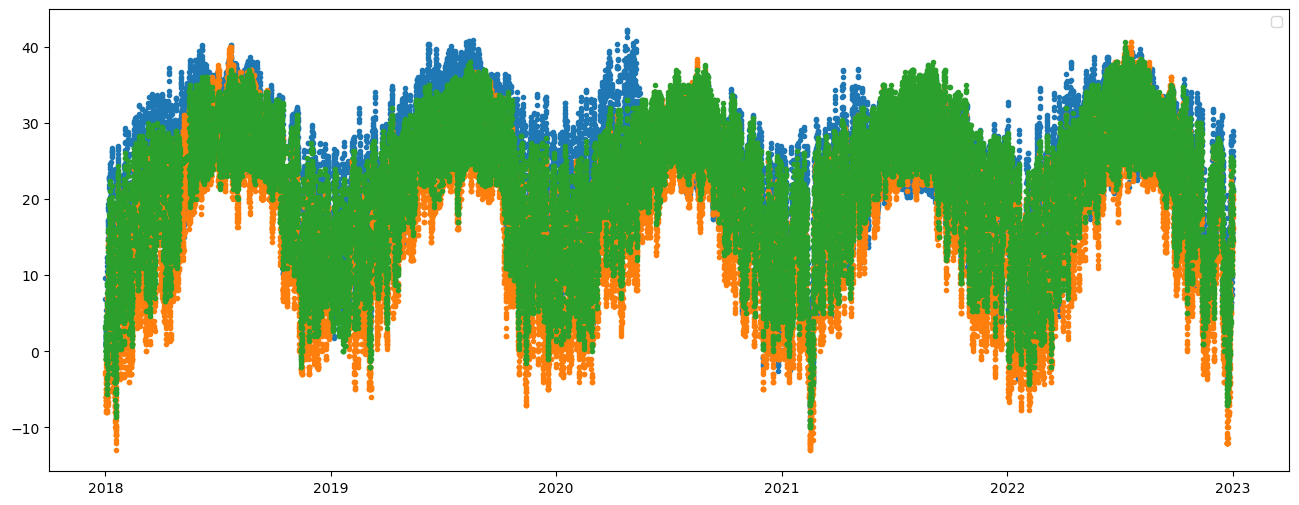

In [222]:
#Plot the data for three different temperatures (BKS, JDD, TME)
fig=plt.figure(figsize=(16,6), linewidth=3)
plt.plot(merged_df.set_index('timestamp')[['tmpc_1', 'tmpc_2', 'tmpc_3']],'.')
plt.legend()

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

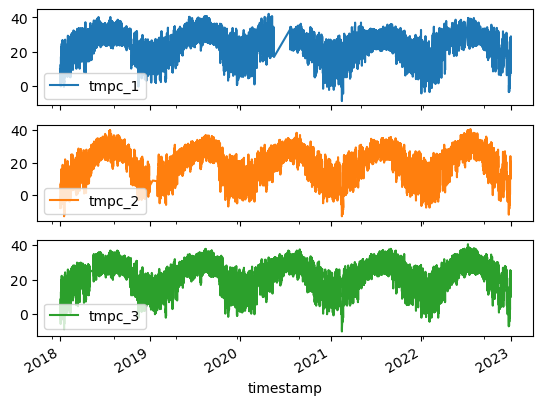

In [223]:
#subplots 'tmpc' data
merged_df.set_index('timestamp')[['tmpc_1', 'tmpc_2', 'tmpc_3']].plot(subplots = True)

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

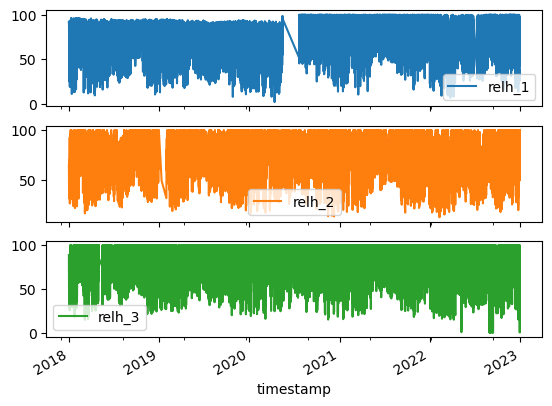

In [224]:
#subplots 'relh' data
merged_df.set_index('timestamp')[['relh_1', 'relh_2', 'relh_3']].plot(subplots = True)

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

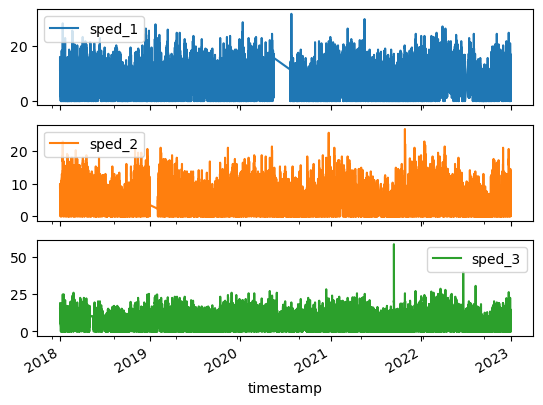

In [225]:
#subplots 'wind sped' data
merged_df.set_index('timestamp')[['sped_1', 'sped_2', 'sped_3']].plot(subplots = True)

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

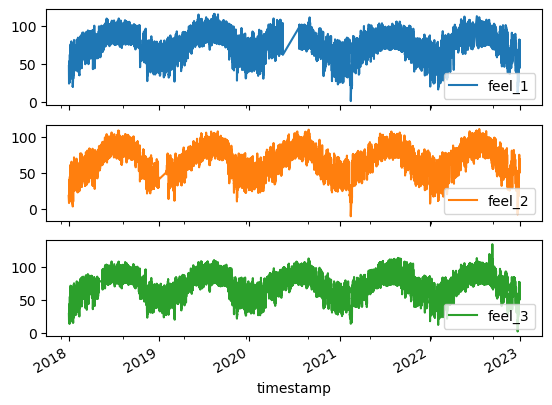

In [226]:
#subplots 'feel like' data
merged_df.set_index('timestamp')[['feel_1', 'feel_2', 'feel_3']].plot(subplots = True)

In [227]:
merged_df.count()

timestamp    43818
tmpc_1       43818
relh_1       43818
sped_1       43818
feel_1       43818
tmpc_2       43818
relh_2       43818
sped_2       43818
feel_2       43818
tmpc_3       43818
relh_3       43818
sped_3       43818
feel_3       43818
ERCOT        43818
dtype: int64

In [228]:
merged_df.set_index('timestamp', inplace=True)

merged_df = merged_df.sort_index()

In [229]:
merged_df

,tmpc_1,relh_1,sped_1,feel_1,tmpc_2,relh_2,sped_2,feel_2,tmpc_3,relh_3,sped_3,feel_3,ERCOT
timestamp,,,,,,,,,,,,,
2018-01-01 01:00:00,9.646667,91.630000,11.500000,47.323333,-2.666667,65.060000,8.816667,18.483333,3.333333,88.873333,15.716667,29.016667,50567.069682
2018-01-01 02:00:00,6.890000,91.330000,16.100000,37.216667,-3.000000,63.270000,9.966667,17.100000,3.000000,86.690000,16.100000,28.130000,50617.087977
2018-01-01 03:00:00,5.463333,92.543333,14.183333,34.406667,-3.333333,64.906667,5.750000,19.340000,3.000000,82.663333,16.483333,28.006667,50694.300087
2018-01-01 04:00:00,4.536667,91.646667,14.183333,32.310000,-4.000000,61.426667,7.666667,16.320000,3.000000,80.650000,16.483333,28.006667,50999.591693
2018-01-01 05:00:00,3.740000,92.086667,12.650000,31.056667,-5.000000,59.566667,8.050000,13.900000,2.333333,84.610000,14.566667,27.090000,51723.732017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 20:00:00,28.313333,29.173333,12.266667,81.146667,20.500000,49.335000,9.200000,68.900000,25.000000,11.200000,12.266667,77.000000,40881.875030
2022-12-31 21:00:00,28.943333,26.956667,11.116667,81.806667,20.000000,52.510000,6.325000,68.000000,25.000000,54.416667,10.350000,77.000000,39635.695638
2022-12-31 22:00:00,28.426667,25.680000,10.350000,81.006667,20.000000,50.236667,5.750000,68.000000,24.333333,22.560000,9.583333,75.800000,38605.054006


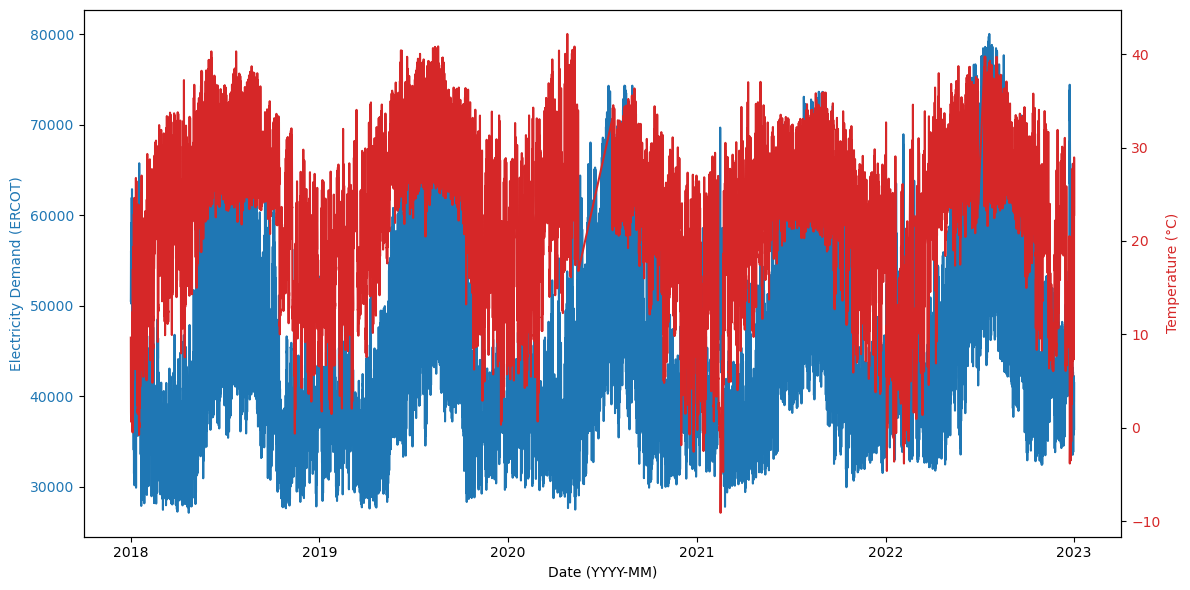

In [230]:
# Plot data
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date (YYYY-MM)')
ax1.set_ylabel('Electricity Demand (ERCOT)', color=color)
ax1.plot(merged_df.index, merged_df['ERCOT'], '-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperature (°C)', color=color)
ax2.plot(merged_df.index, merged_df['tmpc_1'], '-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
# plt.xlim(datetime.datetime(2020, 5, 1), datetime.datetime(2020, 10, 1))
fig.tight_layout()
plt.show()

### **1st I used only one feature (ERCOT) for LSTM Model**

In [231]:
# Define the features to be scaled
features_to_scale = ['ERCOT']

In [232]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df[features_to_scale])

In [233]:
scaled_data

array([[0.44288678],
       [0.44383232],
       [0.44529193],
       ...,
       [0.2167577 ],
       [0.19398315],
       [0.17506044]])

In [234]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [235]:
# Prepare data for LSTM model
def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size):
        data_x.append(dataset[i:(i + window_size), :])
        data_y.append(dataset[i + window_size, 0])
    return np.array(data_x), np.array(data_y)

In [236]:
# Create datasets for LSTM
window_size = 1
learning_rate = 0.001
train_x, train_y = create_dataset(train_data, window_size)
test_x, test_y = create_dataset(test_data, window_size)

In [237]:
# Reshape input to [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2]))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], test_x.shape[2]))

In [238]:
# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(100, input_shape=(window_size, train_x.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# optimizer = Adam(learning_rate=learning_rate)
# model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

In [239]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(window_size, train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = Adam(learning_rate = learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])


C:\Users\Sajib\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [240]:
# Train the model
history = model.fit(train_x, train_y, epochs=100, batch_size=64, validation_data=(test_x, test_y), verbose=0)


In [241]:
# Make predictions with LSTM model
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [242]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,705 (479.32 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,804 (319.55 KB)

In [243]:
# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], train_x.shape[2] - 1))), axis=1))[:, 0]
train_y = scaler.inverse_transform(np.concatenate((train_y.reshape(-1, 1), np.zeros((train_y.shape[0], train_x.shape[2] - 1))), axis=1))[:, 0]

test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], test_x.shape[2] - 1))), axis=1))[:, 0]
test_y = scaler.inverse_transform(np.concatenate((test_y.reshape(-1, 1), np.zeros((test_y.shape[0], test_x.shape[2] - 1))), axis=1))[:, 0]


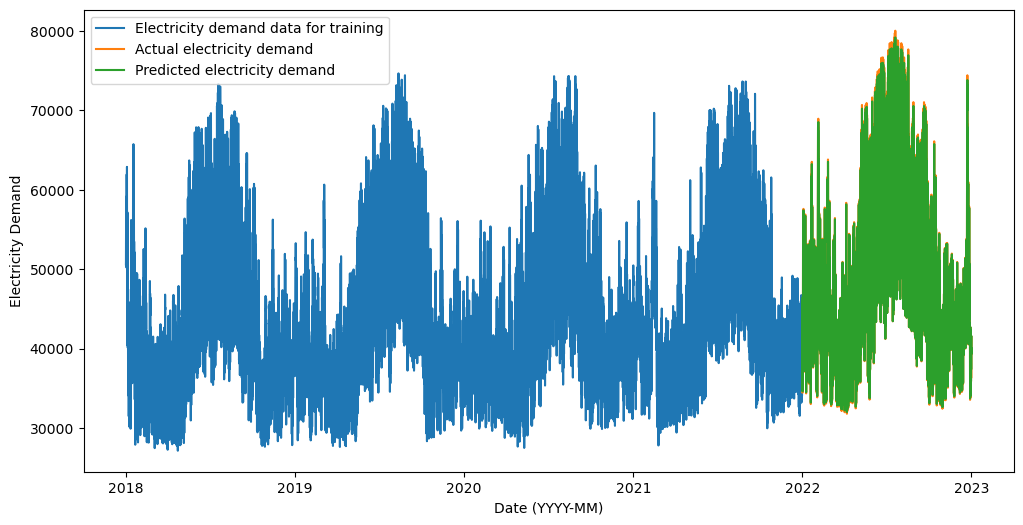

In [244]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[:len(train_y)], train_y, label="Electricity demand data for training")
plt.plot(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_y, label="Actual electricity demand")
plt.plot(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_predict, label="Predicted electricity demand")
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Electricity Demand')
plt.legend()
plt.show()

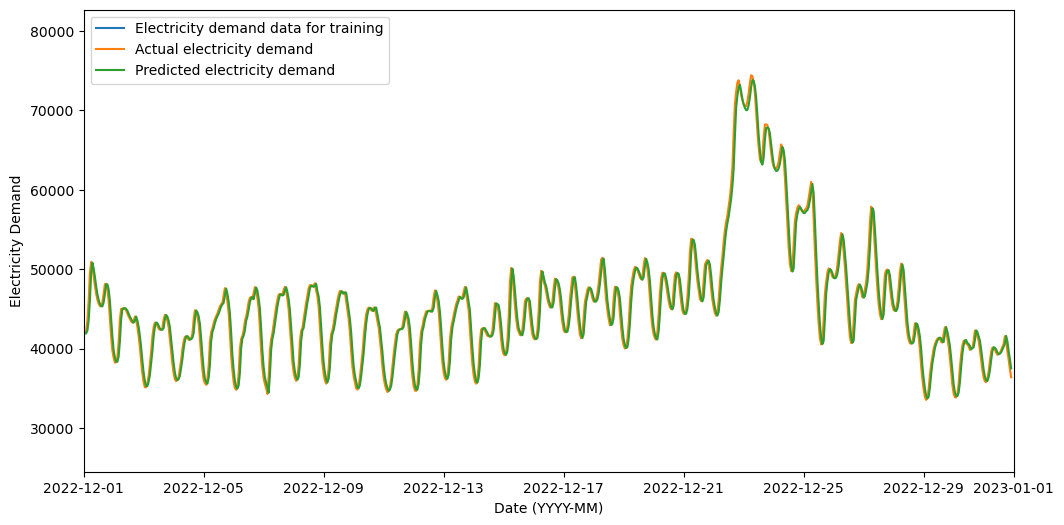

In [245]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[:len(train_y)], train_y, label="Electricity demand data for training")
plt.plot(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_y, label="Actual electricity demand")
plt.plot(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_predict, label="Predicted electricity demand")
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Electricity Demand')
plt.legend()
plt.xlim(datetime.datetime(2022, 12, 1), datetime.datetime(2023, 1, 1))
plt.show()

In [246]:
# Calculate RMSE
train_rmse = sqrt(mean_squared_error(train_y, train_predict))
test_rmse = sqrt(mean_squared_error(test_y, test_predict))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 1798.224662113816
Test RMSE: 1935.4473829690035


In [247]:
# Calculate Mean Absolute Error (MAE) Percentage
MAE_percentage = np.nanmean(np.abs(test_y - test_predict) / np.mean(test_y)) * 100

# Calculate Root Mean Square Error (RMSE) Percentage
RMSE_percentage = (test_rmse / np.mean(test_y)) * 100

# Calculate Root Mean Square Error (RMSE) in Units
RMSE_units = sqrt(mean_squared_error(test_y, test_predict))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(test_y, test_predict) * 100

print(f'Mean Absolute Error Percentage: {MAE_percentage:.2f}%')
print(f'Root Mean Square Error Percentage: {RMSE_percentage:.2f}%')
print(f'Root Mean Square Error (Units): {RMSE_units:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Final accuracy (inverse of MAPE)
final_accuracy = 100 - mape
print(f'Final Accuracy: {final_accuracy:.2f}%')

Mean Absolute Error Percentage: 3.18%
Root Mean Square Error Percentage: 3.94%
Root Mean Square Error (Units): 1935.45
Mean Absolute Percentage Error (MAPE): 3.14%
Final Accuracy: 96.86%


In [248]:
# Calculate RMSE
train_rmse = sqrt(mean_squared_error(train_y, train_predict))
test_rmse = sqrt(mean_squared_error(test_y, test_predict))

# Calculate MAE
train_mae = mean_absolute_error(train_y, train_predict)
test_mae = mean_absolute_error(test_y, test_predict)

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Train MAE: {train_mae:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Train RMSE: 1798.2247
Test RMSE: 1935.4474
Train MAE: 1436.5670
Test MAE: 1562.6922


# **More features-Add (wearther)**

In [249]:
# Define the features to be scaled
features_to_scale = ['ERCOT',
    'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
    'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
    'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
]

In [250]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df[features_to_scale])

In [251]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [252]:
np.shape(train_data)

(35054, 13)

In [253]:
# Prepare data for LSTM model
def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size):
        data_x.append(dataset[i:(i + window_size), :])
        data_y.append(dataset[i + window_size, 0])
    return np.array(data_x), np.array(data_y)

In [254]:
# Create datasets for LSTM
window_size = 1
learning_rate = 0.001
train_x, train_y = create_dataset(train_data, window_size)
test_x, test_y = create_dataset(test_data, window_size)

In [255]:
# Reshape input to [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], train_x.shape[2]))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], test_x.shape[2]))


In [256]:
# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(100, input_shape=(window_size, train_x.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# optimizer = Adam(learning_rate=learning_rate)
# model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

In [257]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(window_size, train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = Adam(learning_rate = learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
#model.compile(optimizer='adam', loss='mse', metrics=['mae'])


C:\Users\Sajib\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [258]:
# Train the model 
history = model.fit(train_x, train_y, epochs=100, batch_size=64, validation_data=(test_x, test_y), verbose=0)


In [259]:
#Save the model
#model.save('my_lstm_model_ERCOT.h5')
model.save('my_lstm_model_ERCOT.keras')

In [260]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100)                 │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,105 (535.57 KB)

 Trainable params: 45,701 (178.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,404 (357.05 KB)

In [261]:
# Make predictions with LSTM model
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [262]:
# Inverse transform predictions to original scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], train_x.shape[2] - 1))), axis=1))[:, 0]
train_y = scaler.inverse_transform(np.concatenate((train_y.reshape(-1, 1), np.zeros((train_y.shape[0], train_x.shape[2] - 1))), axis=1))[:, 0]

test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], test_x.shape[2] - 1))), axis=1))[:, 0]
test_y = scaler.inverse_transform(np.concatenate((test_y.reshape(-1, 1), np.zeros((test_y.shape[0], test_x.shape[2] - 1))), axis=1))[:, 0]


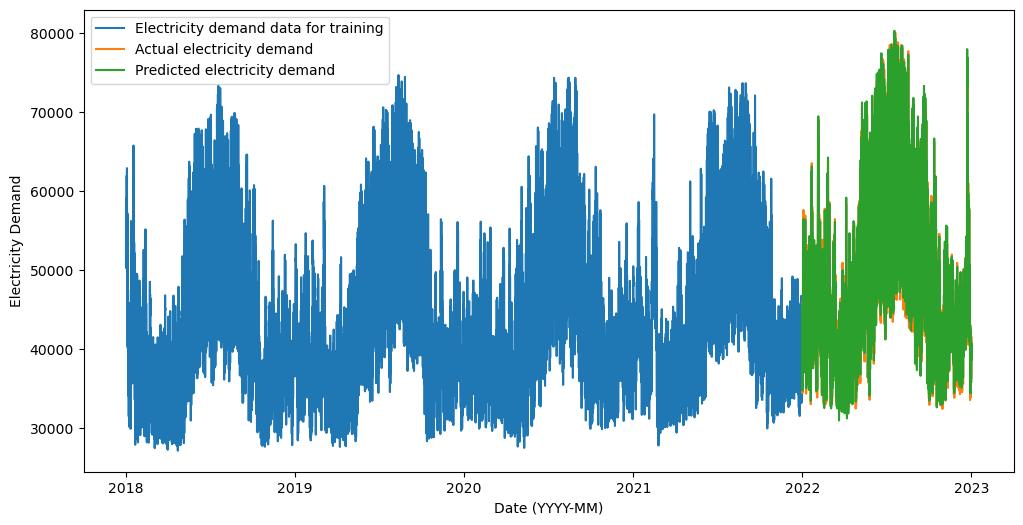

In [263]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[:len(train_y)], train_y, label="Electricity demand data for training")
plt.plot(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_y, label="Actual electricity demand")
plt.plot(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_predict, label="Predicted electricity demand")
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Electricity Demand')
plt.legend()
plt.show()

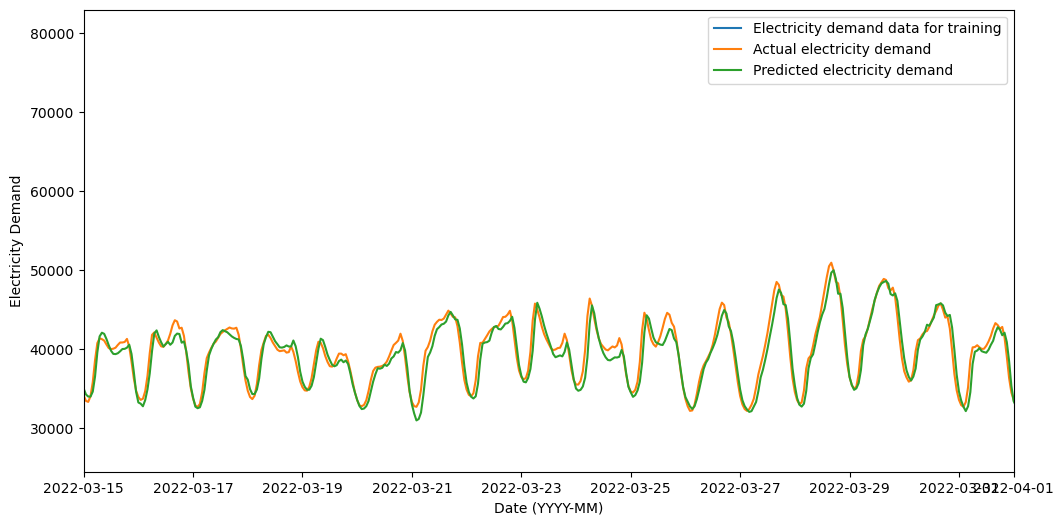

In [264]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[:len(train_y)], train_y, label="Electricity demand data for training")
plt.plot(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_y, label="Actual electricity demand")
plt.plot(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_predict,'-', label="Predicted electricity demand")
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Electricity Demand')
plt.legend()
plt.xlim(datetime.datetime(2022, 3, 15), datetime.datetime(2022, 4, 1))
# Save the plot as an image
#plt.savefig('electricity_demand_prediction2.png', dpi=300)
plt.show()

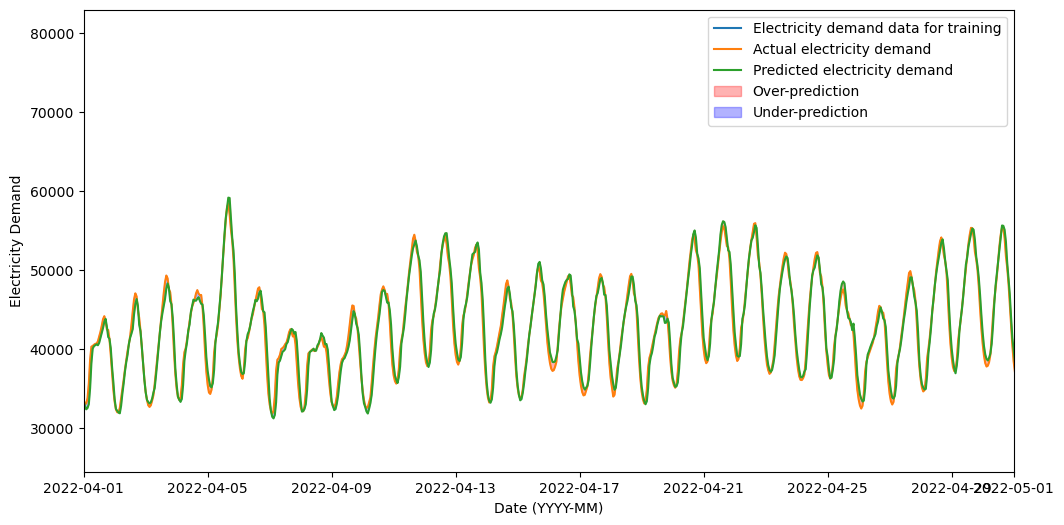

In [265]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[:len(train_y)], train_y, label="Electricity demand data for training")
plt.plot(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_y, label="Actual electricity demand")
plt.plot(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_predict, '-', label="Predicted electricity demand")

# Highlight prediction errors
over_pred = test_predict > test_y
under_pred = test_predict < test_y

plt.fill_between(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_y, test_predict,
                 where=over_pred, interpolate=True, color='red', alpha=0.3, label='Over-prediction')
plt.fill_between(merged_df.index[len(train_y):len(train_y) + len(test_y)], test_y, test_predict,
                 where=under_pred, interpolate=True, color='blue', alpha=0.3, label='Under-prediction')

plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Electricity Demand')
plt.legend()
plt.xlim(datetime.datetime(2022, 4, 1), datetime.datetime(2022, 5, 1))
plt.show()


In [266]:
# Calculate Mean Absolute Error (MAE) Percentage
MAE_percentage = np.nanmean(np.abs(test_y - test_predict) / np.mean(test_y)) * 100

# Calculate Root Mean Square Error (RMSE) Percentage
RMSE_percentage = (test_rmse / np.mean(test_y)) * 100

# Calculate Root Mean Square Error (RMSE) in Units
RMSE_units = sqrt(mean_squared_error(test_y, test_predict))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(test_y, test_predict) * 100

print(f'Mean Absolute Error Percentage: {MAE_percentage:.2f}%')
print(f'Root Mean Square Error Percentage: {RMSE_percentage:.2f}%')
print(f'Root Mean Square Error (Units): {RMSE_units:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Final accuracy (inverse of MAPE)
final_accuracy = 100 - mape
print(f'Final Accuracy: {final_accuracy:.2f}%')

Mean Absolute Error Percentage: 2.06%
Root Mean Square Error Percentage: 3.94%
Root Mean Square Error (Units): 1294.18
Mean Absolute Percentage Error (MAPE): 2.12%
Final Accuracy: 97.88%


In [267]:
# Calculate RMSE
train_rmse = sqrt(mean_squared_error(train_y, train_predict))
test_rmse = sqrt(mean_squared_error(test_y, test_predict))

# Calculate MAE
train_mae = mean_absolute_error(train_y, train_predict)
test_mae = mean_absolute_error(test_y, test_predict)

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Train MAE: {train_mae:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Train RMSE: 1204.8368
Test RMSE: 1294.1765
Train MAE: 929.5650
Test MAE: 1009.3160


# **New 2023 Data and features test in the LSTM Model**

In [268]:
filename = 'Data/2023 test data/Native_Load_2023.xlsx'
df_scada_2023 = pd.read_excel(filename)


In [269]:
df_scada_2023

,Hour Ending,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2023 01:00,8514.637876,1218.506271,5073.526557,917.394049,9896.757586,2859.017922,6012.400469,1116.933155,35609.173887
1,01/01/2023 02:00,8345.632899,1179.885576,5016.774637,906.854582,9675.869720,2845.779210,5934.084260,1107.417972,35012.298856
2,01/01/2023 03:00,8125.706879,1151.144653,5016.303220,894.817013,9490.332365,2734.163642,5855.790279,1101.324245,34369.582295
3,01/01/2023 04:00,7995.083655,1153.306928,5038.003823,891.733538,9420.890470,2555.339795,5840.914307,1105.457821,34000.730337
4,01/01/2023 05:00,7906.920393,1168.779618,4994.502755,896.893843,9430.780728,2484.777679,5873.683697,1108.739956,33865.078669
...,...,...,...,...,...,...,...,...,...,...
8755,12/31/2023 20:00,11918.024426,1499.025843,6126.267426,1254.822945,12423.897835,3403.832421,6972.382083,1152.985583,44751.238564
8756,12/31/2023 21:00,11634.439863,1500.317000,6140.141144,1245.641978,12226.078295,3247.225591,6742.135888,1156.842391,43892.822150
8757,12/31/2023 22:00,11360.099483,1469.102629,6173.751239,1266.036106,12039.301095,3114.176086,6518.290964,1172.912329,43113.669932
8758,12/31/2023 23:00,11096.765551,1462.729993,6117.843863,1282.175278,11844.794085,2995.066870,6276.090426,1169.121304,42244.587370


In [270]:
df_scada_2023 = df_scada_2023.rename(columns={'Hour Ending': 'timestamp'})

In [271]:
df_scada_2023

,timestamp,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2023 01:00,8514.637876,1218.506271,5073.526557,917.394049,9896.757586,2859.017922,6012.400469,1116.933155,35609.173887
1,01/01/2023 02:00,8345.632899,1179.885576,5016.774637,906.854582,9675.869720,2845.779210,5934.084260,1107.417972,35012.298856
2,01/01/2023 03:00,8125.706879,1151.144653,5016.303220,894.817013,9490.332365,2734.163642,5855.790279,1101.324245,34369.582295
3,01/01/2023 04:00,7995.083655,1153.306928,5038.003823,891.733538,9420.890470,2555.339795,5840.914307,1105.457821,34000.730337
4,01/01/2023 05:00,7906.920393,1168.779618,4994.502755,896.893843,9430.780728,2484.777679,5873.683697,1108.739956,33865.078669
...,...,...,...,...,...,...,...,...,...,...
8755,12/31/2023 20:00,11918.024426,1499.025843,6126.267426,1254.822945,12423.897835,3403.832421,6972.382083,1152.985583,44751.238564
8756,12/31/2023 21:00,11634.439863,1500.317000,6140.141144,1245.641978,12226.078295,3247.225591,6742.135888,1156.842391,43892.822150
8757,12/31/2023 22:00,11360.099483,1469.102629,6173.751239,1266.036106,12039.301095,3114.176086,6518.290964,1172.912329,43113.669932
8758,12/31/2023 23:00,11096.765551,1462.729993,6117.843863,1282.175278,11844.794085,2995.066870,6276.090426,1169.121304,42244.587370


In [272]:
df_scada_2023 = df_scada_2023[["ERCOT", "timestamp"]]

In [273]:
df_scada_2023 

,ERCOT,timestamp
0,35609.173887,01/01/2023 01:00
1,35012.298856,01/01/2023 02:00
2,34369.582295,01/01/2023 03:00
3,34000.730337,01/01/2023 04:00
4,33865.078669,01/01/2023 05:00
...,...,...
8755,44751.238564,12/31/2023 20:00
8756,43892.822150,12/31/2023 21:00
8757,43113.669932,12/31/2023 22:00
8758,42244.587370,12/31/2023 23:00


In [274]:
def convert_timestamp(df):
  converted_count = 0

  for i in range(len(df)):
    try:
      # Attempt conversion for each row
      timestamp_str = df.loc[i, 'timestamp']
      if not pd.isna(timestamp_str):  # Check for NaN before conversion
        df.loc[i, 'timestamp'] = pd.to_datetime(timestamp_str, errors='coerce')
        converted_count += 1
    except pd.errors.OutOfBoundsDatetime:
      # Handle potential conversion errors
      print(f"Warning: Encountered invalid timestamp at row {i}. Data might be corrupted.")

  # Handle missing values (NaN) after conversion attempts
  df['timestamp'] = df['timestamp'].fillna(method='ffill')  # Forward fill

  df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
  print(f"Successfully converted {converted_count} timestamps.")
  return df

# Apply the conversion function with error handling
df_scada_2023 = convert_timestamp(df_scada_2023.copy())


C:\Users\Sajib\AppData\Local\Temp\ipykernel_12376\2322915457.py:9: FutureWarning: Parsed string "11/05/2023 02:00 DST" included an un-recognized timezone "DST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df.loc[i, 'timestamp'] = pd.to_datetime(timestamp_str, errors='coerce')


Successfully converted 8760 timestamps.


C:\Users\Sajib\AppData\Local\Temp\ipykernel_12376\2322915457.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['timestamp'] = df['timestamp'].fillna(method='ffill')  # Forward fill


In [275]:
df_scada_new

,Hour Ending,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2023 01:00,8514.637876,1218.506271,5073.526557,917.394049,9896.757586,2859.017922,6012.400469,1116.933155,35609.173887
1,01/01/2023 02:00,8345.632899,1179.885576,5016.774637,906.854582,9675.869720,2845.779210,5934.084260,1107.417972,35012.298856
2,01/01/2023 03:00,8125.706879,1151.144653,5016.303220,894.817013,9490.332365,2734.163642,5855.790279,1101.324245,34369.582295
3,01/01/2023 04:00,7995.083655,1153.306928,5038.003823,891.733538,9420.890470,2555.339795,5840.914307,1105.457821,34000.730337
4,01/01/2023 05:00,7906.920393,1168.779618,4994.502755,896.893843,9430.780728,2484.777679,5873.683697,1108.739956,33865.078669
...,...,...,...,...,...,...,...,...,...,...
8755,12/31/2023 20:00,11918.024426,1499.025843,6126.267426,1254.822945,12423.897835,3403.832421,6972.382083,1152.985583,44751.238564
8756,12/31/2023 21:00,11634.439863,1500.317000,6140.141144,1245.641978,12226.078295,3247.225591,6742.135888,1156.842391,43892.822150
8757,12/31/2023 22:00,11360.099483,1469.102629,6173.751239,1266.036106,12039.301095,3114.176086,6518.290964,1172.912329,43113.669932
8758,12/31/2023 23:00,11096.765551,1462.729993,6117.843863,1282.175278,11844.794085,2995.066870,6276.090426,1169.121304,42244.587370


In [276]:
# Save the sorted DataFrame to a .csv file
df_scada_2023.to_csv('2023_electricity_demand_data.csv', index=False)

In [277]:
# Load and preprocess electricity demand data
data_path2 = 'Data/Hourly weather data/'
files = glob.glob(data_path2 + "asos_hourly_*.csv")
df_merge_all2 = pd.read_csv(files[2])


In [278]:
files

['Data/Hourly weather data\\asos_hourly_BKS.csv',
 'Data/Hourly weather data\\asos_hourly_JDD.csv',
 'Data/Hourly weather data\\asos_hourly_TME.csv']

In [279]:
# Define the file paths
file_paths2 = [
 'Data/Hourly weather data\\asos_hourly_BKS.csv',
 'Data/Hourly weather data\\asos_hourly_JDD.csv',
 'Data/Hourly weather data\\asos_hourly_TME.csv'
]

In [280]:
# Define a function to read and rename columns of a single file
def read_and_rename(file_path2, suffix):
    df = pd.read_csv(file_path2)
    df['timestamp'] = pd.to_datetime(df['timestamp'])  
    df = df.rename(columns=lambda x: f"{x}_{suffix}" if x != 'timestamp' else x)
    return df

In [281]:
# Read and rename columns of all files
dfs2 = [read_and_rename(file_paths2[i], i+1) for i in range(len(file_paths2))]

In [282]:
# Merge all dataframes on 'timestamp'
df2_weather = dfs2[0]
for df in dfs[1:]:
    df2_weather = pd.merge(df2_weather, df, on='timestamp', how='outer')

In [283]:
df2_weather

,timestamp,tmpc_1,relh_1,sped_1,feel_1,p01m_1,tmpc_2,relh_2,sped_2,feel_2,p01m_2,tmpc_3,relh_3,sped_3,feel_3,p01m_3
0,2016-01-01 00:00:00,10.353333,89.003333,5.750000,50.600000,0.0,NaN,NaN,3.833333,NaN,0.000000,11.666667,63.646667,7.666667,53.000000,0.0
1,2016-01-01 01:00:00,10.560000,88.620000,3.066667,50.960000,0.0,NaN,NaN,1.533333,NaN,0.000000,10.333333,76.350000,8.050000,48.270000,0.0
2,2016-01-01 02:00:00,10.653333,88.836667,1.533333,51.200000,0.0,NaN,NaN,2.683333,NaN,0.000000,10.000000,79.800000,8.816667,46.446667,0.0
3,2016-01-01 03:00:00,11.240000,82.583333,3.066667,52.220000,0.0,NaN,NaN,6.133333,NaN,0.000000,10.000000,77.990000,9.200000,46.303333,0.0
4,2016-01-01 04:00:00,11.613333,76.300000,6.516667,52.940000,0.0,NaN,NaN,4.600000,NaN,0.000000,10.000000,74.476667,9.583333,46.160000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73843,2024-06-03 19:00:00,37.220000,47.510000,14.566667,113.206667,0.0,28.666667,80.616667,10.350000,93.056667,0.000000,33.000000,66.830000,16.483333,107.760000,0.0
73844,2024-06-03 20:00:00,37.650000,46.890000,16.483333,114.650000,0.0,29.333333,77.563333,10.350000,95.156667,0.000000,33.000000,61.680000,17.633333,104.256667,0.0
73845,2024-06-03 21:00:00,37.816667,46.876667,11.883333,115.440000,0.0,29.666667,76.086667,8.433333,96.153333,0.000000,33.000000,61.680000,16.483333,104.256667,0.0
73846,2024-06-03 22:00:00,37.443333,48.316667,13.800000,115.000000,0.0,27.333333,80.420000,3.833333,88.486667,0.000000,31.666667,67.850000,16.100000,101.666667,0.0


In [284]:
df_scada_2023['timestamp'] = pd.to_datetime(df_scada_2023['timestamp'])
df2_weather['timestamp'] = pd.to_datetime(df2_weather['timestamp'])

In [285]:
# Merge df_scada with mergedAll_df on 'timestamp'
merged_df2 = pd.merge_asof(df_scada_2023, df2_weather, on='timestamp')

In [286]:
merged_df2

,ERCOT,timestamp,tmpc_1,relh_1,sped_1,feel_1,p01m_1,tmpc_2,relh_2,sped_2,feel_2,p01m_2,tmpc_3,relh_3,sped_3,feel_3,p01m_3
0,35609.173887,2023-01-01 01:00:00,20.390000,47.216667,9.200000,68.700000,0.0,16.333333,69.163333,4.216667,61.4,0.0,17.666667,90.110000,8.433333,63.80,0.0
1,35012.298856,2023-01-01 02:00:00,18.646667,75.650000,8.050000,65.566667,0.0,16.000000,67.540000,3.833333,60.8,0.0,17.000000,95.886667,7.666667,62.60,0.0
2,34369.582295,2023-01-01 03:00:00,17.056667,95.546667,4.600000,62.700000,0.0,16.333333,66.153333,4.983333,61.4,0.0,15.000000,100.000000,4.216667,59.90,0.0
3,34000.730337,2023-01-01 04:00:00,16.576667,100.000000,6.133333,61.833333,0.0,17.000000,63.380000,4.983333,62.6,0.0,13.666667,100.000000,0.000000,60.08,0.0
4,33865.078669,2023-01-01 05:00:00,15.926667,100.000000,4.600000,60.666667,0.0,16.000000,66.076667,5.366667,60.8,0.0,14.333333,100.000000,4.600000,60.26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,44751.238564,2023-12-31 20:00:00,26.093333,50.116667,18.783333,78.966667,0.0,18.000000,31.850000,6.133333,64.4,0.0,22.666667,47.686667,13.800000,72.80,0.0
8756,43892.822150,2023-12-31 21:00:00,26.073333,49.753333,16.100000,78.933333,0.0,18.000000,33.430000,5.366667,64.4,0.0,23.000000,47.773333,12.650000,73.40,0.0
8757,43113.669932,2023-12-31 22:00:00,25.743333,51.483333,11.500000,78.333333,0.0,17.333333,37.556667,2.683333,63.2,0.0,21.666667,56.623333,11.116667,71.00,0.0
8758,42244.587370,2023-12-31 23:00:00,24.276667,57.093333,9.200000,75.700000,0.0,13.333333,53.360000,0.000000,56.0,0.0,19.666667,68.670000,8.433333,67.40,0.0


In [287]:
merged_df2=merged_df2.interpolate(method='linear')

In [288]:
merged_df2

,ERCOT,timestamp,tmpc_1,relh_1,sped_1,feel_1,p01m_1,tmpc_2,relh_2,sped_2,feel_2,p01m_2,tmpc_3,relh_3,sped_3,feel_3,p01m_3
0,35609.173887,2023-01-01 01:00:00,20.390000,47.216667,9.200000,68.700000,0.0,16.333333,69.163333,4.216667,61.4,0.0,17.666667,90.110000,8.433333,63.80,0.0
1,35012.298856,2023-01-01 02:00:00,18.646667,75.650000,8.050000,65.566667,0.0,16.000000,67.540000,3.833333,60.8,0.0,17.000000,95.886667,7.666667,62.60,0.0
2,34369.582295,2023-01-01 03:00:00,17.056667,95.546667,4.600000,62.700000,0.0,16.333333,66.153333,4.983333,61.4,0.0,15.000000,100.000000,4.216667,59.90,0.0
3,34000.730337,2023-01-01 04:00:00,16.576667,100.000000,6.133333,61.833333,0.0,17.000000,63.380000,4.983333,62.6,0.0,13.666667,100.000000,0.000000,60.08,0.0
4,33865.078669,2023-01-01 05:00:00,15.926667,100.000000,4.600000,60.666667,0.0,16.000000,66.076667,5.366667,60.8,0.0,14.333333,100.000000,4.600000,60.26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,44751.238564,2023-12-31 20:00:00,26.093333,50.116667,18.783333,78.966667,0.0,18.000000,31.850000,6.133333,64.4,0.0,22.666667,47.686667,13.800000,72.80,0.0
8756,43892.822150,2023-12-31 21:00:00,26.073333,49.753333,16.100000,78.933333,0.0,18.000000,33.430000,5.366667,64.4,0.0,23.000000,47.773333,12.650000,73.40,0.0
8757,43113.669932,2023-12-31 22:00:00,25.743333,51.483333,11.500000,78.333333,0.0,17.333333,37.556667,2.683333,63.2,0.0,21.666667,56.623333,11.116667,71.00,0.0
8758,42244.587370,2023-12-31 23:00:00,24.276667,57.093333,9.200000,75.700000,0.0,13.333333,53.360000,0.000000,56.0,0.0,19.666667,68.670000,8.433333,67.40,0.0


In [289]:
# Save the sorted DataFrame to a .csv file
merged_df2.to_csv('2023_all_data.csv', index=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


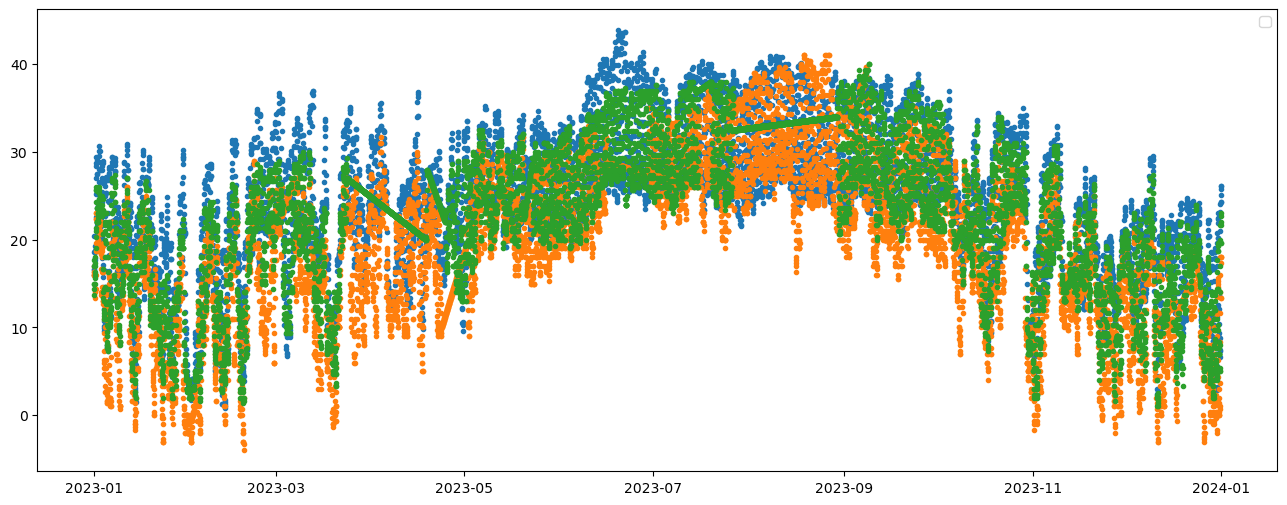

In [290]:
fig=plt.figure(figsize=(16,6), linewidth=3)
plt.plot(merged_df2.set_index('timestamp')[['tmpc_1', 'tmpc_2', 'tmpc_3']],'.')
plt.legend()

In [291]:
# merged_df2.set_index('timestamp', inplace=True)

In [292]:
merged_df2

,ERCOT,timestamp,tmpc_1,relh_1,sped_1,feel_1,p01m_1,tmpc_2,relh_2,sped_2,feel_2,p01m_2,tmpc_3,relh_3,sped_3,feel_3,p01m_3
0,35609.173887,2023-01-01 01:00:00,20.390000,47.216667,9.200000,68.700000,0.0,16.333333,69.163333,4.216667,61.4,0.0,17.666667,90.110000,8.433333,63.80,0.0
1,35012.298856,2023-01-01 02:00:00,18.646667,75.650000,8.050000,65.566667,0.0,16.000000,67.540000,3.833333,60.8,0.0,17.000000,95.886667,7.666667,62.60,0.0
2,34369.582295,2023-01-01 03:00:00,17.056667,95.546667,4.600000,62.700000,0.0,16.333333,66.153333,4.983333,61.4,0.0,15.000000,100.000000,4.216667,59.90,0.0
3,34000.730337,2023-01-01 04:00:00,16.576667,100.000000,6.133333,61.833333,0.0,17.000000,63.380000,4.983333,62.6,0.0,13.666667,100.000000,0.000000,60.08,0.0
4,33865.078669,2023-01-01 05:00:00,15.926667,100.000000,4.600000,60.666667,0.0,16.000000,66.076667,5.366667,60.8,0.0,14.333333,100.000000,4.600000,60.26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,44751.238564,2023-12-31 20:00:00,26.093333,50.116667,18.783333,78.966667,0.0,18.000000,31.850000,6.133333,64.4,0.0,22.666667,47.686667,13.800000,72.80,0.0
8756,43892.822150,2023-12-31 21:00:00,26.073333,49.753333,16.100000,78.933333,0.0,18.000000,33.430000,5.366667,64.4,0.0,23.000000,47.773333,12.650000,73.40,0.0
8757,43113.669932,2023-12-31 22:00:00,25.743333,51.483333,11.500000,78.333333,0.0,17.333333,37.556667,2.683333,63.2,0.0,21.666667,56.623333,11.116667,71.00,0.0
8758,42244.587370,2023-12-31 23:00:00,24.276667,57.093333,9.200000,75.700000,0.0,13.333333,53.360000,0.000000,56.0,0.0,19.666667,68.670000,8.433333,67.40,0.0


**Add features in model**

In [293]:
merged_df2 = merged_df2.drop(['p01m_1', 'p01m_2', 'p01m_3'], axis=1)

In [294]:
merged_df2

,ERCOT,timestamp,tmpc_1,relh_1,sped_1,feel_1,tmpc_2,relh_2,sped_2,feel_2,tmpc_3,relh_3,sped_3,feel_3
0,35609.173887,2023-01-01 01:00:00,20.390000,47.216667,9.200000,68.700000,16.333333,69.163333,4.216667,61.4,17.666667,90.110000,8.433333,63.80
1,35012.298856,2023-01-01 02:00:00,18.646667,75.650000,8.050000,65.566667,16.000000,67.540000,3.833333,60.8,17.000000,95.886667,7.666667,62.60
2,34369.582295,2023-01-01 03:00:00,17.056667,95.546667,4.600000,62.700000,16.333333,66.153333,4.983333,61.4,15.000000,100.000000,4.216667,59.90
3,34000.730337,2023-01-01 04:00:00,16.576667,100.000000,6.133333,61.833333,17.000000,63.380000,4.983333,62.6,13.666667,100.000000,0.000000,60.08
4,33865.078669,2023-01-01 05:00:00,15.926667,100.000000,4.600000,60.666667,16.000000,66.076667,5.366667,60.8,14.333333,100.000000,4.600000,60.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,44751.238564,2023-12-31 20:00:00,26.093333,50.116667,18.783333,78.966667,18.000000,31.850000,6.133333,64.4,22.666667,47.686667,13.800000,72.80
8756,43892.822150,2023-12-31 21:00:00,26.073333,49.753333,16.100000,78.933333,18.000000,33.430000,5.366667,64.4,23.000000,47.773333,12.650000,73.40
8757,43113.669932,2023-12-31 22:00:00,25.743333,51.483333,11.500000,78.333333,17.333333,37.556667,2.683333,63.2,21.666667,56.623333,11.116667,71.00
8758,42244.587370,2023-12-31 23:00:00,24.276667,57.093333,9.200000,75.700000,13.333333,53.360000,0.000000,56.0,19.666667,68.670000,8.433333,67.40


In [295]:
merged_df2.set_index('timestamp', inplace=True)

In [296]:
merged_df2

,ERCOT,tmpc_1,relh_1,sped_1,feel_1,tmpc_2,relh_2,sped_2,feel_2,tmpc_3,relh_3,sped_3,feel_3
timestamp,,,,,,,,,,,,,
2023-01-01 01:00:00,35609.173887,20.390000,47.216667,9.200000,68.700000,16.333333,69.163333,4.216667,61.4,17.666667,90.110000,8.433333,63.80
2023-01-01 02:00:00,35012.298856,18.646667,75.650000,8.050000,65.566667,16.000000,67.540000,3.833333,60.8,17.000000,95.886667,7.666667,62.60
2023-01-01 03:00:00,34369.582295,17.056667,95.546667,4.600000,62.700000,16.333333,66.153333,4.983333,61.4,15.000000,100.000000,4.216667,59.90
2023-01-01 04:00:00,34000.730337,16.576667,100.000000,6.133333,61.833333,17.000000,63.380000,4.983333,62.6,13.666667,100.000000,0.000000,60.08
2023-01-01 05:00:00,33865.078669,15.926667,100.000000,4.600000,60.666667,16.000000,66.076667,5.366667,60.8,14.333333,100.000000,4.600000,60.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 20:00:00,44751.238564,26.093333,50.116667,18.783333,78.966667,18.000000,31.850000,6.133333,64.4,22.666667,47.686667,13.800000,72.80
2023-12-31 21:00:00,43892.822150,26.073333,49.753333,16.100000,78.933333,18.000000,33.430000,5.366667,64.4,23.000000,47.773333,12.650000,73.40
2023-12-31 22:00:00,43113.669932,25.743333,51.483333,11.500000,78.333333,17.333333,37.556667,2.683333,63.2,21.666667,56.623333,11.116667,71.00


In [297]:
features = ['ERCOT',
    'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
    'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
    'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
]

In [298]:
# Normalize the weather features using the same scaler
scaler = MinMaxScaler(feature_range=(0, 1))  
scaled_features = scaler.fit_transform(merged_df2[features])

In [299]:
# Reshape the data to match LSTM input shape (samples, time steps, features)
scaled_features = np.reshape(scaled_features, (scaled_features.shape[0], 1, scaled_features.shape[1]))

In [300]:
scaled_features

array([[[0.04430284, 0.45391116, 0.41271372, ..., 0.90020182,
         0.17254902, 0.42382282]],

       [[0.03286101, 0.41336538, 0.72907317, ..., 0.9584931 ,
         0.15686275, 0.41060016]],

       [[0.02054042, 0.37638577, 0.95045062, ..., 1.        ,
         0.08627451, 0.38084919]],

       ...,

       [[0.18816071, 0.57841693, 0.46018618, ..., 0.56229398,
         0.22745098, 0.50315875]],

       [[0.17150078, 0.54430576, 0.52260505, ..., 0.68385469,
         0.17254902, 0.46349078]],

       [[0.15956546, 0.54430576, 0.52260505, ..., 0.68385469,
         0.17254902, 0.46349078]]])

In [301]:
look_back = 24 

In [302]:
# Load the pre-trained LSTM model
model = load_model('my_lstm_model_ERCOT.keras')

In [303]:
# Make predictions
predicted_demand = model.predict(scaled_features)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [304]:
# Inverse transform predictions to original scale
predicted_demand = scaler.inverse_transform(np.concatenate((predicted_demand, np.zeros((predicted_demand.shape[0], scaled_features.shape[2] - 1))), axis=1))[:, 0]


In [305]:
predicted_demand

array([36151.54397293, 35716.28630645, 34939.33408386, ...,
       43138.24509943, 42229.2820163 , 41601.61691733])

In [306]:
# Load or generate timestamps for 2023 (replace this with your actual timestamps)
timestamps_2023 = pd.date_range(start='2023-01-01', end='2023-12-31 23:00:00', freq='H')

In [307]:
# The length of timestamps_2023 matches the length of predicted_demand
if len(timestamps_2023) != len(predicted_demand):
    raise ValueError("Timestamps and predicted demand arrays must have the same length")

In [308]:
predicted_demand_df = pd.DataFrame({
    'timestamp': timestamps_2023,  
    'predicted_demand': predicted_demand
})

In [309]:
# Display or use the predicted_demand_df DataFrame as needed
print(predicted_demand_df.head())

            timestamp  predicted_demand
0 2023-01-01 00:00:00      36151.543973
1 2023-01-01 01:00:00      35716.286306
2 2023-01-01 02:00:00      34939.334084
3 2023-01-01 03:00:00      34624.547745
4 2023-01-01 04:00:00      34282.585786


In [310]:
predicted_demand_df.to_csv('2023_demand_updated.csv', index=False)

In [311]:
# Load predicted demand data (predicted_demand_df)
predicted_demand_df = pd.read_csv('2023_demand_updated.csv')  

In [312]:
predicted_demand_df

,timestamp,predicted_demand
0,2023-01-01 00:00:00,36151.543973
1,2023-01-01 01:00:00,35716.286306
2,2023-01-01 02:00:00,34939.334084
3,2023-01-01 03:00:00,34624.547745
4,2023-01-01 04:00:00,34282.585786
...,...,...
8755,2023-12-31 19:00:00,45273.533692
8756,2023-12-31 20:00:00,44326.123636
8757,2023-12-31 21:00:00,43138.245099
8758,2023-12-31 22:00:00,42229.282016


In [313]:
# Load actual electricity demand data for 2023
actual_demand_df = pd.read_csv('2023_electricity_demand_data.csv') 

In [314]:
actual_demand_df

,ERCOT,timestamp
0,35609.173887,2023-01-01 01:00
1,35012.298856,2023-01-01 02:00
2,34369.582295,2023-01-01 03:00
3,34000.730337,2023-01-01 04:00
4,33865.078669,2023-01-01 05:00
...,...,...
8755,44751.238564,2023-12-31 20:00
8756,43892.822150,2023-12-31 21:00
8757,43113.669932,2023-12-31 22:00
8758,42244.587370,2023-12-31 23:00


In [315]:
predicted_demand_df['timestamp'] = pd.to_datetime(predicted_demand_df['timestamp'])
actual_demand_df['timestamp'] = pd.to_datetime(actual_demand_df['timestamp'])

In [316]:
merged_df = pd.merge( predicted_demand_df, actual_demand_df, on='timestamp')

In [317]:
merged_df

,timestamp,predicted_demand,ERCOT
0,2023-01-01 01:00:00,35716.286306,35609.173887
1,2023-01-01 02:00:00,34939.334084,35012.298856
2,2023-01-01 03:00:00,34624.547745,34369.582295
3,2023-01-01 04:00:00,34282.585786,34000.730337
4,2023-01-01 05:00:00,34747.257796,33865.078669
...,...,...,...
8755,2023-12-31 20:00:00,44326.123636,44751.238564
8756,2023-12-31 21:00:00,43138.245099,43892.822150
8757,2023-12-31 22:00:00,42229.282016,43113.669932
8758,2023-12-31 23:00:00,41601.616917,42244.587370


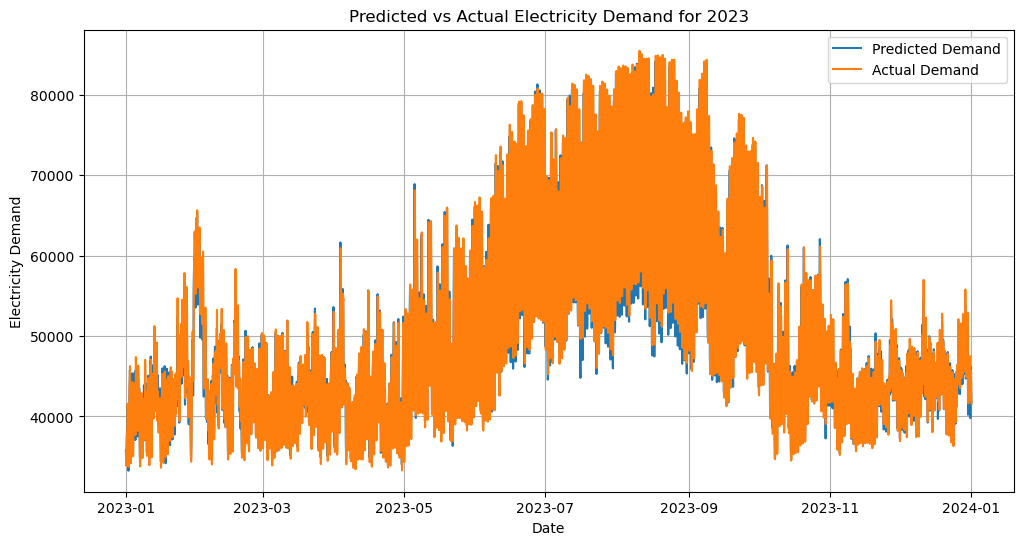

In [318]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(merged_df['timestamp'], merged_df['predicted_demand'], label='Predicted Demand')
plt.plot(merged_df['timestamp'], merged_df['ERCOT'], label='Actual Demand')
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.title('Predicted vs Actual Electricity Demand for 2023')
plt.legend()
plt.grid(True)
plt.show()

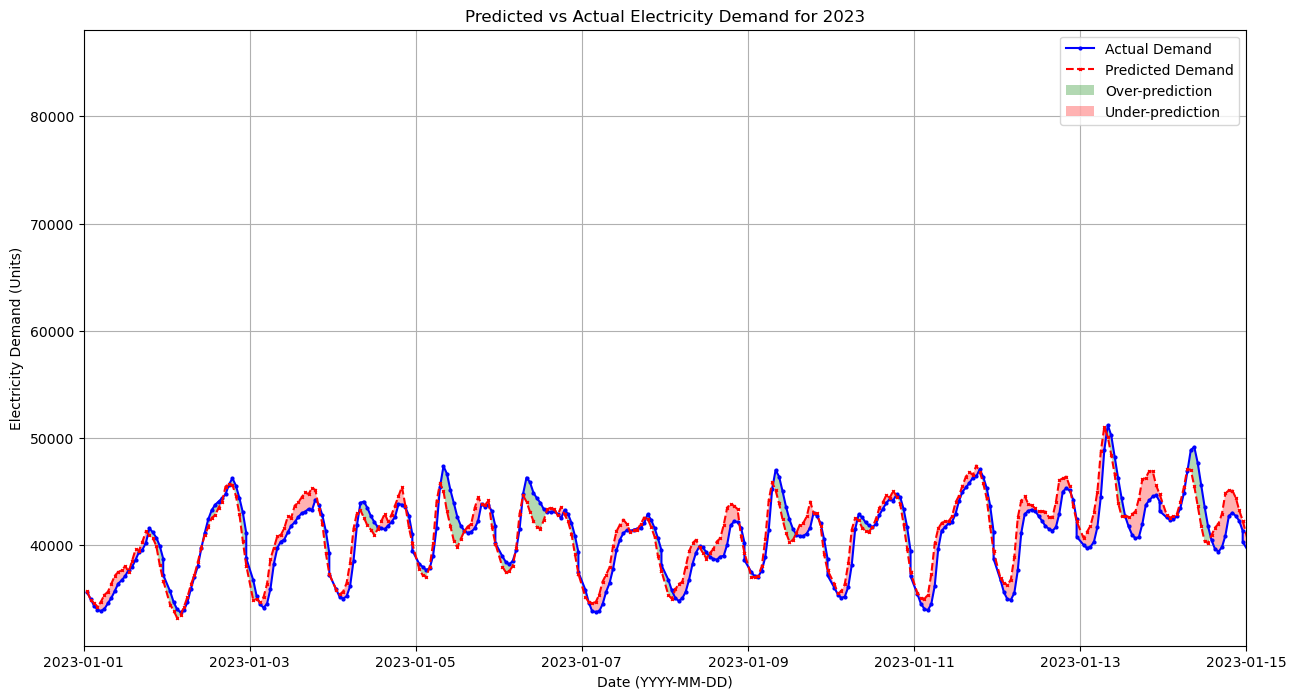

In [319]:

# Plotting
plt.figure(figsize=(15, 8))

# Plot actual demand
plt.plot(merged_df['timestamp'], merged_df['ERCOT'], label='Actual Demand', color='blue', linestyle='-', marker='o', markersize=2)

# Plot predicted demand
plt.plot(merged_df['timestamp'], merged_df['predicted_demand'], label='Predicted Demand', color='red', linestyle='--', marker='x', markersize=2)

# Highlight prediction errors
plt.fill_between(merged_df['timestamp'], merged_df['ERCOT'], merged_df['predicted_demand'], where=(merged_df['ERCOT'] >= merged_df['predicted_demand']), facecolor='green', interpolate=True, alpha=0.3, label='Over-prediction')
plt.fill_between(merged_df['timestamp'], merged_df['ERCOT'], merged_df['predicted_demand'], where=(merged_df['ERCOT'] < merged_df['predicted_demand']), facecolor='red', interpolate=True, alpha=0.3, label='Under-prediction')

plt.xlabel('Date (YYYY-MM-DD)')
plt.ylabel('Electricity Demand (Units)')
plt.title('Predicted vs Actual Electricity Demand for 2023')
plt.legend()
plt.grid(True)
plt.xlim(datetime.datetime(2023, 1, 1), datetime.datetime(2023, 1, 15))
plt.show()

In [320]:
# Calculate metrics
mae = mean_absolute_error(merged_df['ERCOT'], merged_df['predicted_demand'])
rmse = np.sqrt(mean_squared_error(merged_df['ERCOT'], merged_df['predicted_demand']))
mape = mean_absolute_percentage_error(merged_df['ERCOT'], merged_df['predicted_demand'])
accuracy = 100 - mape * 100

In [321]:
# Calculate percentage errors
mae_percentage = (mae / merged_df['ERCOT'].mean()) * 100
rmse_percentage = (rmse / merged_df['ERCOT'].mean()) * 100

In [322]:
print(f"Mean Absolute Error Percentage: {mae_percentage:.2f}%")
print(f"Root Mean Square Error Percentage: {rmse_percentage:.2f}%")
print(f"Root Mean Square Error (Units): {rmse:.2f}")
print(f"Final Accuracy: {accuracy:.2f}%")

Mean Absolute Error Percentage: 6.36%
Root Mean Square Error Percentage: 8.65%
Root Mean Square Error (Units): 4387.88
Final Accuracy: 94.02%
